In [ ]:
!pip install -q transformers datasets
!pip install -q transformers==4.23.1

In [ ]:
pip install git+https://github.com/huggingface/datasets

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
data = load_dataset("imagefolder", data_files= "./CatDog.zip", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
#Observe the dataset
data

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [6]:
#Split
split = data.train_test_split(test_size=0.2)
split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

In [7]:
#Further split (to get validation part)
split02 = split['test'].train_test_split(test_size=0.5)
split02

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [8]:
train_ds = split['train']
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 800
})

In [9]:
test_ds = split02['test']
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

In [10]:
val_ds = split02['train']
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

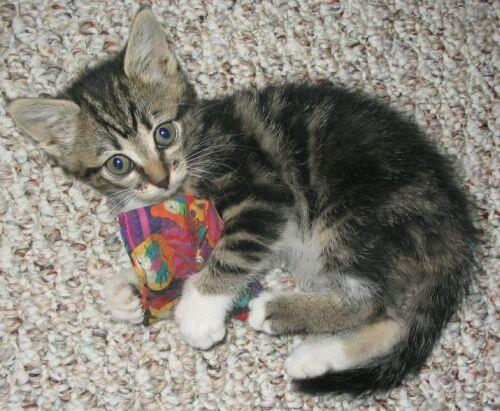

In [11]:
#Example
train_ds[0]['image']

In [12]:
train_ds[0]['label']

0

In [13]:
#Index to label and vice versa dicts
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'cat', 1: 'dog'}

In [14]:
#Feature extractor
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [15]:
#Apply transforms to dataset for data augmentation, normalization and resizing

from torchvision.transforms import (ToTensor,
                                    CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   ToTensor(),
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            #ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            ToTensor(),
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            #ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [16]:
#Apply transforms on training, testing and validation sets
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [17]:
#Create PyTorch Dataloader
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [19]:
#Import pretrained ViT Image Classifier
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=2,
                                                  id2label=id2label,
                                                  label2id=label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate

In [23]:
#Set the training arguements
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"cat-dog",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [25]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [26]:
#Train
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anotherfakeofhis (anotherfakeofhis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.226964,1.000000
2,No log,0.126900,1.000000


***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to cat-dog/checkpoint-80
Configuration saved in cat-dog/checkpoint-80/config.json
Model weights saved in cat-dog/checkpoint-80/pytorch_model.bin
Feature extractor saved in cat-dog/checkpoint-80/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 100
  Batch size = 4
Saving model checkpoint to cat-dog/checkpoint-160
Configuration saved in cat-dog/checkpoint-160/config.json
Model weights saved in cat-dog/checkpoint-160/pytorch_model.bin
Feature extractor saved in cat-dog/checkpoint-160/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from cat-dog/checkpoint-80 (score: 1.0).


TrainOutput(global_step=160, training_loss=0.3309232473373413, metrics={'train_runtime': 126.9649, 'train_samples_per_second': 12.602, 'train_steps_per_second': 1.26, 'total_flos': 1.239871833833472e+17, 'train_loss': 0.3309232473373413, 'epoch': 2.0})

In [27]:
#Test
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 100
  Batch size = 4


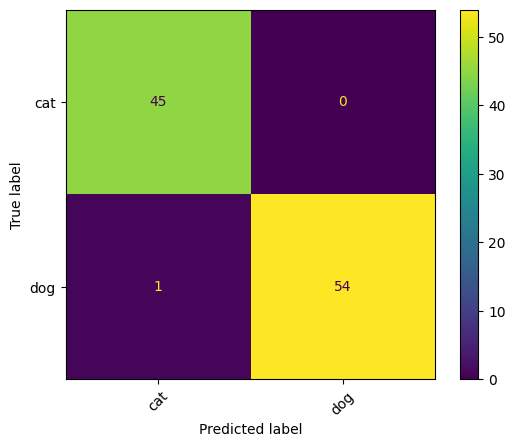

In [28]:
#Performance Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [29]:
Accuracy = accuracy_score(y_true, y_pred, normalize=True)
Accuracy

0.99